In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import random

from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans

from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm

# Electricity demand

## Descriptive Analysis

In [2]:
#Read in electricity demand data of all 28 households
#Then concate single csv data to one dateframe
dfConcat = pd.read_csv('Input_Data//dataverse_files//Residential_1.csv')
dfConcat['month'] = pd.to_datetime(dfConcat['date']).dt.month

#Filter for outliers
dfConcat = dfConcat[dfConcat['energy_kWh'] < dfConcat.describe().loc['mean']['energy_kWh'] + 3*dfConcat.describe().loc['std']['energy_kWh']]
dfConcat['nr'] = 1
#dfConcat.drop('date', axis=1, inplace=True)

for i in range(2,29):
    fileName = 'Input_Data//dataverse_files//Residential_{}.csv'.format(str(i))
    df = pd.read_csv(fileName)
    df['month'] = pd.to_datetime(df['date']).dt.month
    #df.drop('date', axis=1, inplace=True)
    df['nr'] = i
    df = df[df['energy_kWh'] < df.describe().loc['mean']['energy_kWh'] + 3*df.describe().loc['std']['energy_kWh']]

    dfConcat = pd.concat([dfConcat,df])

dfConcat.head()

,date,hour,energy_kWh,month,nr
0,2012-06-01,1,1.011,6,1
1,2012-06-01,2,0.451,6,1
2,2012-06-01,3,0.505,6,1
3,2012-06-01,4,0.441,6,1
4,2012-06-01,5,0.468,6,1


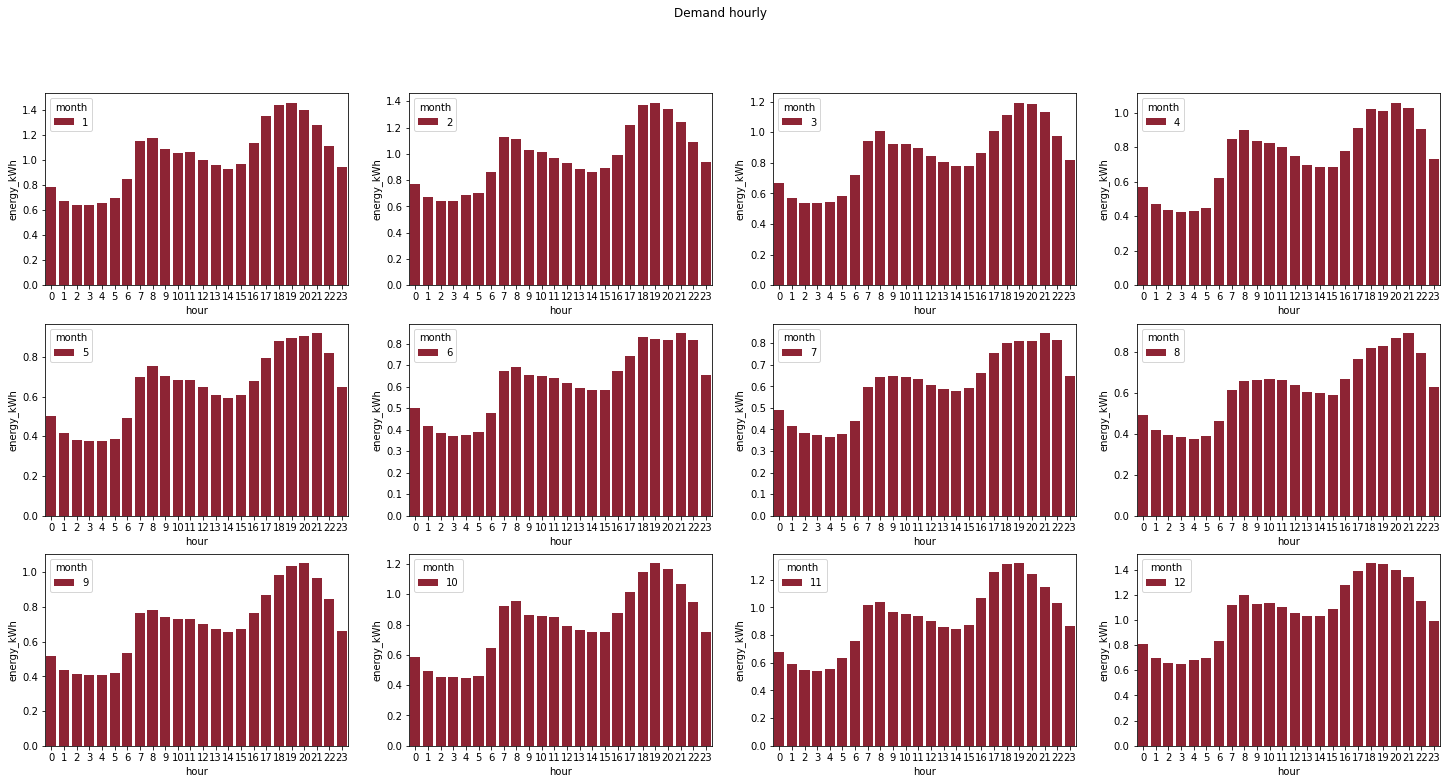

In [3]:
#Plot to see daily pattern in differnet months
dfConcatAggr = dfConcat.groupby(['month','hour']).mean().reset_index()

fig, axs = plt.subplots(3,4,figsize=(25,12))
fig.suptitle('Demand hourly')

sns.barplot(ax=axs[0,0], data=dfConcatAggr[dfConcatAggr['month']==1], x='hour', y='energy_kWh', hue='month', palette=sns.color_palette("RdBu", 12))
sns.barplot(ax=axs[0,1], data=dfConcatAggr[dfConcatAggr['month']==2], x='hour', y='energy_kWh', hue='month', palette=sns.color_palette("RdBu", 12))
sns.barplot(ax=axs[0,2], data=dfConcatAggr[dfConcatAggr['month']==3], x='hour', y='energy_kWh', hue='month', palette=sns.color_palette("RdBu", 12))
sns.barplot(ax=axs[0,3], data=dfConcatAggr[dfConcatAggr['month']==4], x='hour', y='energy_kWh', hue='month', palette=sns.color_palette("RdBu", 12))

sns.barplot(ax=axs[1,0], data=dfConcatAggr[dfConcatAggr['month']==5], x='hour', y='energy_kWh', hue='month', palette=sns.color_palette("RdBu", 12))
sns.barplot(ax=axs[1,1], data=dfConcatAggr[dfConcatAggr['month']==6], x='hour', y='energy_kWh', hue='month', palette=sns.color_palette("RdBu", 12))
sns.barplot(ax=axs[1,2], data=dfConcatAggr[dfConcatAggr['month']==7], x='hour', y='energy_kWh', hue='month', palette=sns.color_palette("RdBu", 12))
sns.barplot(ax=axs[1,3], data=dfConcatAggr[dfConcatAggr['month']==8], x='hour', y='energy_kWh', hue='month', palette=sns.color_palette("RdBu", 12))

sns.barplot(ax=axs[2,0], data=dfConcatAggr[dfConcatAggr['month']==9], x='hour', y='energy_kWh', hue='month', palette=sns.color_palette("RdBu", 12))
sns.barplot(ax=axs[2,1], data=dfConcatAggr[dfConcatAggr['month']==10], x='hour', y='energy_kWh', hue='month', palette=sns.color_palette("RdBu", 12))
sns.barplot(ax=axs[2,2], data=dfConcatAggr[dfConcatAggr['month']==11], x='hour', y='energy_kWh', hue='month', palette=sns.color_palette("RdBu", 12))
sns.barplot(ax=axs[2,3], data=dfConcatAggr[dfConcatAggr['month']==12], x='hour', y='energy_kWh', hue='month', palette=sns.color_palette("RdBu", 12))

fig.savefig("figures//Demand_Hourly.png")

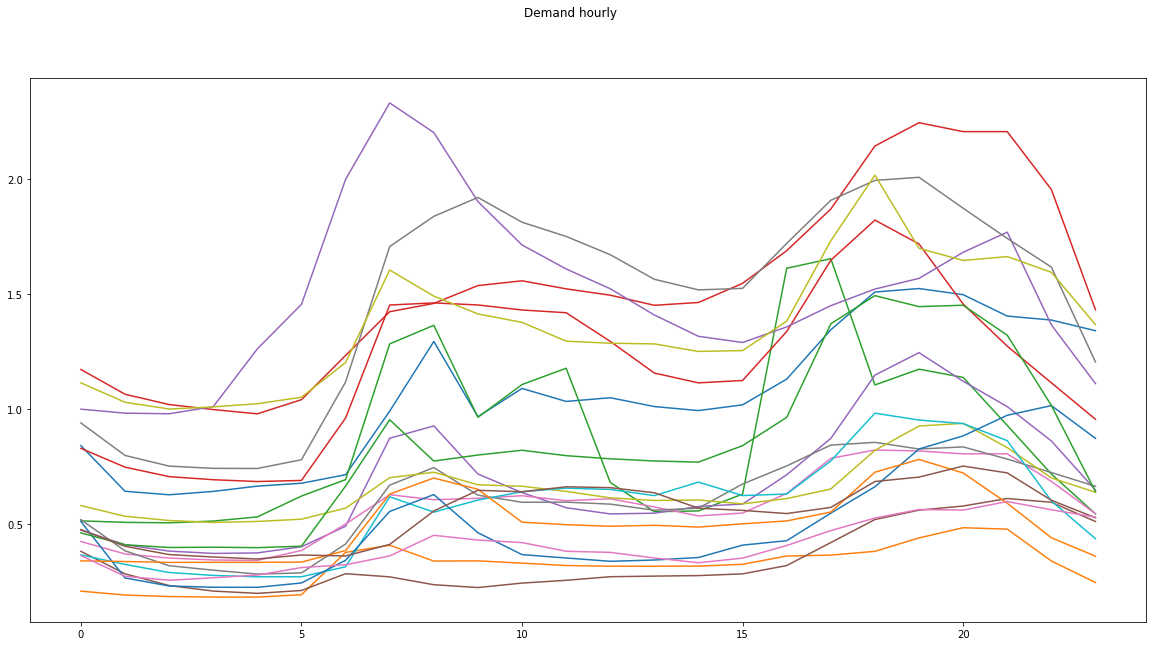

In [4]:
dfConcatAggr2 = dfConcat.groupby(['nr','hour']).mean().reset_index()
dfConcatAggr2.head()

#Plot
fig, axs = plt.subplots(figsize=(20,10))
fig.suptitle('Demand hourly')

for i in range(1,20):
    dff = dfConcatAggr2[dfConcatAggr2['nr'] == i].reset_index()
    plt.plot(dff['energy_kWh'])

It is clear to see that the demand pattern of a day is almost identical in the different months. The only difference between the months is the level of demand. For this reason, the average value for all months is used in the following.

## Scenario Generation
### First get the daily pattern

In [5]:
#Get Average value of all months
dfConcat_hourly = dfConcat.drop('month',axis=1)
dfConcatAggr_hourly = dfConcat_hourly.groupby(['hour']).mean().reset_index()
dfConcatAggr_hourly.head()

,hour,energy_kWh,nr
0,0,0.615777,12.910640
1,1,0.525176,12.920771
2,2,0.491231,12.911565
3,3,0.484826,12.913301
4,4,0.493883,12.913901


<AxesSubplot:xlabel='hour', ylabel='energy_kWh'>

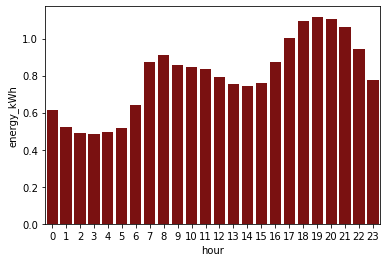

In [6]:
#plot
sns.barplot(data=dfConcatAggr_hourly, x='hour', y='energy_kWh', color='darkred')

In [7]:
### Create a percentual distribution of demand for
avg_daily_demand = dfConcatAggr_hourly['energy_kWh'].sum()
dfConcatAggr_hourly['percentual_energy_consumption'] = dfConcatAggr_hourly['energy_kWh']/avg_daily_demand
dfConcatAggr_hourly.head()

,hour,energy_kWh,nr,percentual_energy_consumption
0,0,0.615777,12.910640,0.032202
1,1,0.525176,12.920771,0.027464
2,2,0.491231,12.911565,0.025689
3,3,0.484826,12.913301,0.025354
4,4,0.493883,12.913901,0.025828


### Now get the yearly pattern

In [8]:
#Use only full years
def filter_full_years(df):

    df['year'] = df['date'].dt.year
    indexList = df['year'].value_counts().index

    useYear = []
    for index in indexList:
        if df['year'].value_counts().loc[index] == 365:
            useYear.append(index)
    
    return df[df['year'].isin(useYear)]

In [9]:
#Again load all data (this time other features and filter for full years needed)
dfConcat = pd.read_csv('Input_Data//dataverse_files//Residential_1.csv')
dfConcat['date'] = pd.to_datetime(dfConcat['date'])
dfConcat['month'] = dfConcat['date'].dt.month

#Filter for outliers
dfConcat.drop('hour',axis=1,inplace=True)

#Get daily demand
dfConcat_daily = dfConcat.groupby(['date','month']).mean().reset_index()
dfConcat_daily_filtered = filter_full_years(dfConcat_daily)

#Filter for outliers
desc = dfConcat_daily_filtered.describe()
dfConcat_daily_filtered = dfConcat_daily_filtered[dfConcat_daily_filtered['energy_kWh'] < desc.loc['mean']['energy_kWh'] + 3*desc.loc['std']['energy_kWh']]

for i in range(2,29):
    fileName = 'Input_Data//dataverse_files//Residential_{}.csv'.format(str(i))
    dfDemand = pd.read_csv(fileName)
    dfDemand['date'] = pd.to_datetime(dfDemand['date'])
    dfDemand['month'] = pd.to_datetime(dfDemand['date']).dt.month

    dfDemand.drop('hour',axis=1,inplace=True)

    #Get hourly mean demand
    dfDemand_daily = dfDemand.groupby(['date','month']).mean().reset_index()
    dfDemand_daily_filtered = filter_full_years(dfDemand_daily)

    #Filter for outliers
    desc = dfDemand_daily_filtered.describe()
    dfDemand_daily_filtered = dfDemand_daily_filtered[dfDemand_daily_filtered['energy_kWh'] < desc.loc['mean']['energy_kWh'] + 3*desc.loc['std']['energy_kWh']]


    dfConcat_daily_filtered = pd.concat([dfConcat_daily_filtered,dfDemand_daily_filtered])

In [10]:
#Get mean of months per year
demand_monthly = dfConcat_daily_filtered.drop('date',axis=1).groupby(['year','month']).mean()
demand_monthly = demand_monthly.reset_index()

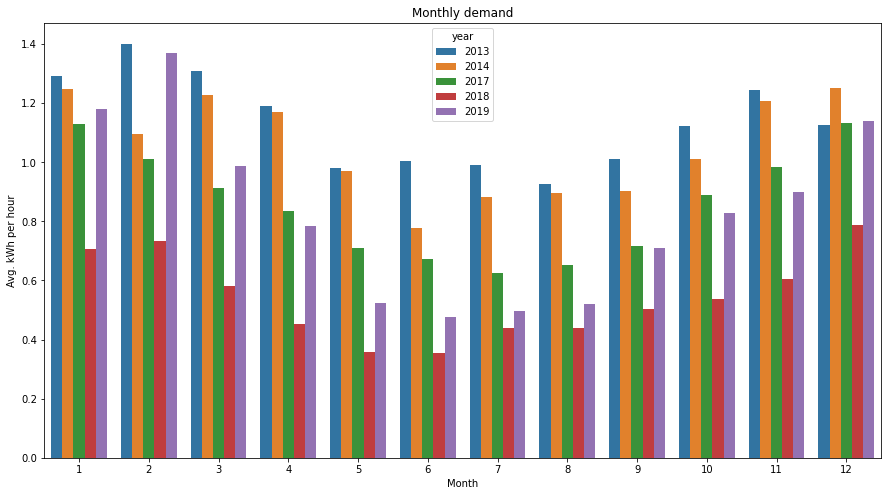

In [11]:
#Plot average demand per month
fig, ax = plt.subplots(figsize=(15,8))
sns.barplot(data=demand_monthly, x='month', y='energy_kWh',hue='year')

ax.set_title('Monthly demand')
ax.set_xlabel('Month')
ax.set_ylabel('Avg. kWh per hour')

fig.savefig("figures//monthly_demand.png")

The pattern is equal for each year, again only the level change. Therefore, as before, create a general pattern.

<AxesSubplot:xlabel='month', ylabel='energy_kWh'>

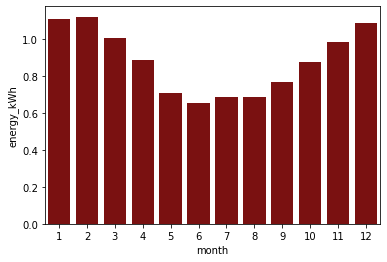

In [12]:
#Get mean of months
demand_monthly.drop('year',axis=1,inplace=True)
demand_monthly = demand_monthly.groupby(['month']).mean()
demand_monthly = demand_monthly.reset_index()

sns.barplot(data=demand_monthly, x='month', y='energy_kWh',color='darkred')

Get percentual proportion of monthly demand

In [13]:
#Get percentual distribution 
demand_complete = demand_monthly['energy_kWh'].sum()
demand_monthly['energy_kWh'] = demand_monthly['energy_kWh']/demand_complete
demand_monthly = demand_monthly.set_index('month')
demand_monthly = demand_monthly.rename(columns={'energy_kWh':'percentual_proportion'})
demand_monthly.head()

,percentual_proportion
month,
1,0.104975
2,0.105990
3,0.094877
4,0.083754
5,0.066987


### Get yearly average values and chain the patterns

In [14]:
#Get yearly average demand = hourly*24*365
dfDemand_yearly = dfConcat_daily_filtered.groupby(['year']).mean()*24*365
dfDemand_yearly = dfDemand_yearly.reset_index()
dfDemand_yearly[['year','energy_kWh']]

,year,energy_kWh
0,2013,9907.781140
1,2014,9221.875734
2,2017,7462.506751
3,2018,4730.835412
4,2019,7177.942843


<AxesSubplot:xlabel='year', ylabel='energy_kWh'>

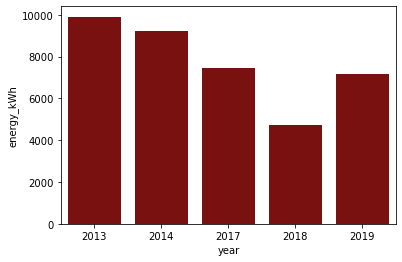

In [15]:
sns.barplot(data = dfDemand_yearly,x='year',y='energy_kWh',color='darkred')

Fit a normal distribution and create values for 25 years

In [16]:
description = dfDemand_yearly.describe()
scenarios = np.random.normal(loc=description.loc['mean']['energy_kWh'], scale=description.loc['std']['energy_kWh'],size=25)

Create daily demand data for the 25 years, resulting in 9125 Data points

In [17]:
daysPerMonth = [31,28,31,30,31,30,31,31,30,31,30,31]

scenarios_daily = []

for scenario in tqdm(range(0,len(scenarios))):

    for month, numberOfDays in enumerate(daysPerMonth):
        for day in range(numberOfDays):
            daily = []
            for hour in range(0,24):
                hourlyDemand = scenarios[scenario] * demand_monthly.iloc[month]['percentual_proportion'] * (1/numberOfDays) * dfConcatAggr_hourly.iloc[hour]['percentual_energy_consumption']
                daily.append(hourlyDemand)

            scenarios_daily.append(daily)
len(scenarios_daily)

100%|██████████| 25/25 [00:40<00:00,  1.62s/it]


9125

### K-Medoids & K-MNeans
Cluster these 9125 daily demands to get a managable amount of scenarios


 11%|█         | 1/9 [00:02<00:19,  2.38s/it]F:\Anaconda\envs\atis_2\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:235: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  "its corresponding cluster ({k}).".format(k=k)
 22%|██▏       | 2/9 [00:04<00:16,  2.40s/it]F:\Anaconda\envs\atis_2\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:235: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  "its corresponding cluster ({k}).".format(k=k)
F:\Anaconda\envs\atis_2\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:235: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  "its corresponding cluster ({k}).".format(k=k)
 33%|███▎      | 3/9 [00:07<00:14,  2.41s/it]F:\Anaconda\envs\atis_2\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:235: UserWarn

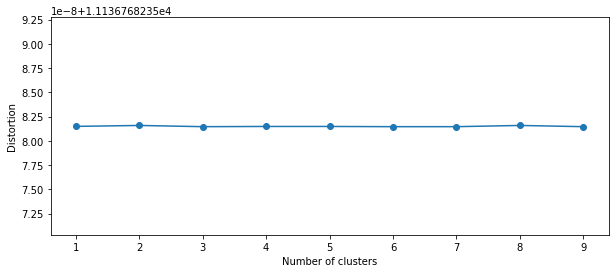

In [18]:
# calculate distortion for a range of number of cluster
NO_CLUSTER = 10
distortions = []
for i in tqdm(range(1, NO_CLUSTER)):
    km = KMedoids(
        n_clusters=i,
        random_state=0
    )
    km.fit(scenarios_daily)
    distortions.append(km.inertia_)

# plot
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(range(1, NO_CLUSTER), distortions, marker='o')

plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

100%|██████████| 9/9 [00:02<00:00,  4.14it/s]


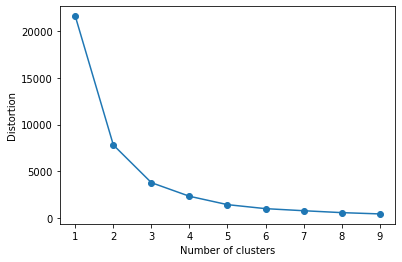

In [19]:
# calculate distortion for a range of number of cluster
NO_CLUSTER = 10
distortions = []
for i in tqdm(range(1, NO_CLUSTER)):
    km = KMeans(
        n_clusters=i, init='k-means++',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(scenarios_daily)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, NO_CLUSTER), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [20]:
km = KMeans(
    n_clusters=3, init='k-means++',
    n_init=10, max_iter=300,
    tol=1e-04, random_state=0
)
km.fit(scenarios_daily)

centers = km.cluster_centers_

### Get probabilities

In [21]:
prediction = km.predict(scenarios_daily)
prediction = pd.Series(prediction)
probability = list(prediction.value_counts()/len(prediction))
probability

[0.4375890410958904, 0.3918904109589041, 0.1705205479452055]

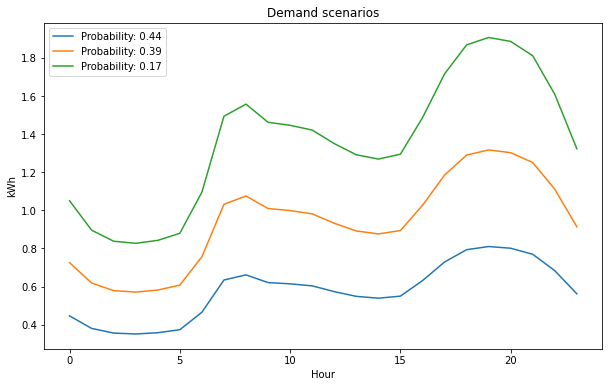

In [22]:
fig, ax = plt.subplots(figsize=(10,6))

for i,center in enumerate(centers):
    plt.plot(center, label="Probability: "+str(round(probability[i],2)))

ax.set_title('Demand scenarios')
ax.set_xlabel('Hour')
ax.set_ylabel('kWh')

plt.legend()
plt.show()

fig.savefig("figures//demand_scenario.png")

In [23]:
dfDemand_Scenario = pd.DataFrame(centers)
dfDemand_Scenario['probability'] = probability
dfDemand_Scenario

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,probability
0,0.446257,0.380598,0.355998,0.351356,0.357920,0.373713,0.465396,0.634600,0.661492,0.621087,...,0.549975,0.631109,0.728777,0.793543,0.810166,0.801335,0.769461,0.683393,0.562114,0.437589
1,0.725473,0.618732,0.578740,0.571194,0.581864,0.607539,0.756587,1.031658,1.075377,1.009691,...,0.894086,1.025984,1.184760,1.290050,1.317074,1.302717,1.250899,1.110982,0.913820,0.391890
2,1.050538,0.895969,0.838059,0.827132,0.842583,0.879761,1.095594,1.493918,1.557226,1.462108,...,1.294703,1.485702,1.715621,1.868089,1.907221,1.886431,1.811395,1.608784,1.323279,0.170521


In [24]:
dfDemand_Scenario.sum(1)

0    14.295512
1    22.920488
2    32.793606
dtype: float64

In [25]:
pd.DataFrame(dfDemand_Scenario).T.to_csv('Output_Scenarios//demand_scenarios.csv',index=False)
pd.DataFrame(dfDemand_Scenario).T.head()

,0,1,2
0,0.446257,0.725473,1.050538
1,0.380598,0.618732,0.895969
2,0.355998,0.578740,0.838059
3,0.351356,0.571194,0.827132
4,0.357920,0.581864,0.842583


# Solar energy production
## Should depend on production of one solar panel unit to be scalable later in the model

## Descriptive Analysis

In [26]:
#Read Data
dfSolar = pd.read_csv('Input_Data//dataverse_files//Solar.csv')
dfSolar.drop('dc_output',axis=1,inplace=True)
dfSolar.head()

,date,hour,ac_output
0,000-01-01,0,0.0
1,000-01-01,1,0.0
2,000-01-01,2,0.0
3,000-01-01,3,0.0
4,000-01-01,4,0.0


In [27]:
#Add feature month and get mean value
months = []

for date in dfSolar['date'].values:
    months.append(int(date.split('-')[1]))

dfSolar['month'] = months
dfSolar.head()

dfSolar_Aggr = dfSolar.groupby(['hour','month']).mean()
dfSolar_Aggr = dfSolar_Aggr.reset_index()

<AxesSubplot:xlabel='hour', ylabel='ac_output'>

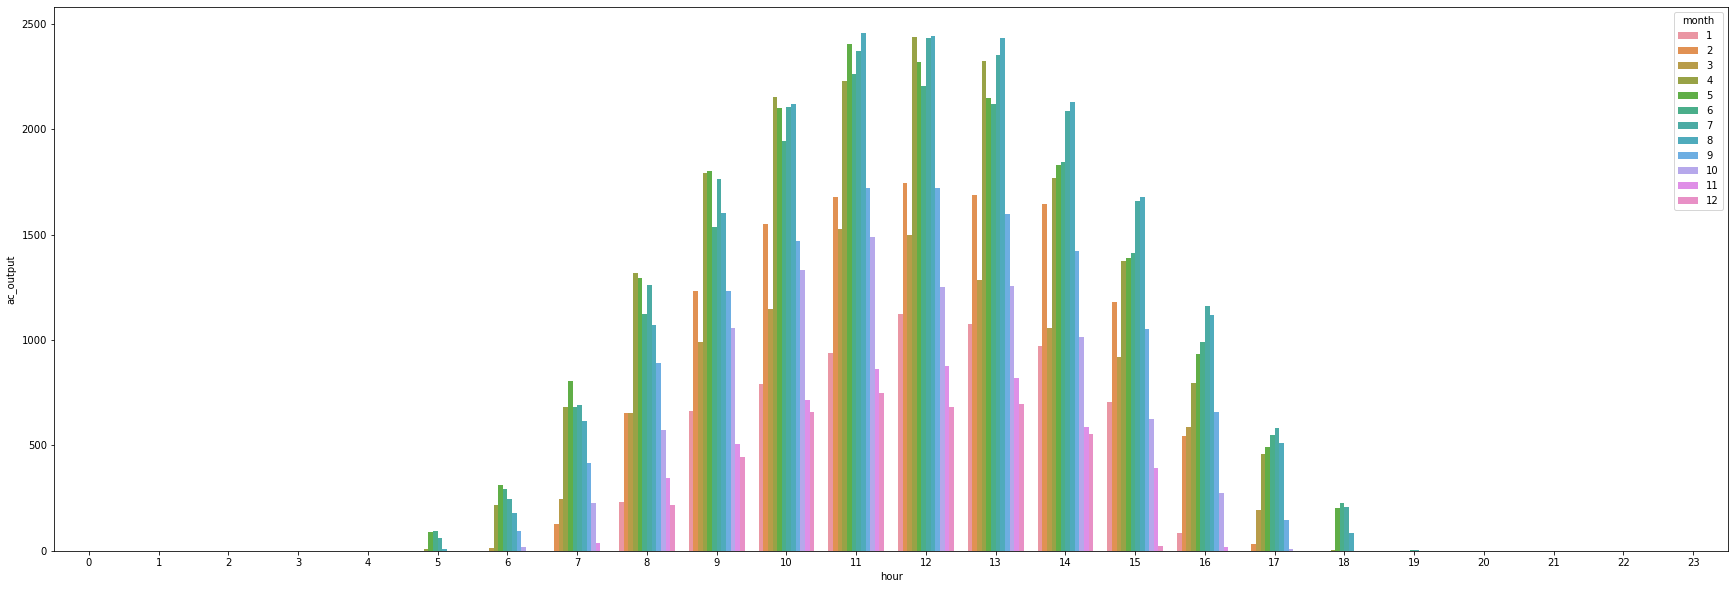

In [28]:
#plot
fig, ax = plt.subplots(figsize=(30,10))
sns.barplot(data=dfSolar_Aggr,x='hour',y='ac_output',hue='month')

## Scenario Generation

### Because we want to apply to own production limit scale to 0-1

In [29]:
#Max production of one solar unit in kWh
#https://www.photovoltaik4all.de/en/solarmodule/aleo-x63-340-premium
#https://www.alma-solarshop.de/solarmodule/1278-sunpower-solarmodule-maxeon-max3-400w.html
maxkWh_Pannel = 0.4
efficientcy_degree = 0.9

maxProduction = maxkWh_Pannel * efficientcy_degree

In [30]:
dfSolar['ac_output'] = MinMaxScaler().fit_transform(dfSolar['ac_output'].to_numpy().reshape(-1,1))
dfSolar['ac_output'] = dfSolar['ac_output']*maxProduction

### Get daily production in single months

In [31]:
base = 0.05
production_scenarios_hourly = []

#Get complete production of each day in month
m_i = dfSolar
m_i_grouped = (m_i.groupby(['date']).sum()['ac_output']).reset_index()
m_i_grouped['ac_output'] = round(base*round(m_i_grouped['ac_output']/base),2)

#Get percentual proportion of single production amounts
m_i_grouped = m_i_grouped.value_counts('ac_output').reset_index()
distribution = m_i_grouped.rename(columns={'ac_output':'daily_production',0:'probability'})
distribution['probability'] = distribution['probability']/distribution['probability'].sum()

daily_production = list(np.random.choice(distribution['daily_production'], p=distribution['probability'], size=1000))

#daily_production = np.random.poisson(distribution['daily_production'].mean(),size=1000)

#Now get hourly production using a distribution.
#First get distribution of production over hours of day
m_i_mean = m_i.groupby('hour').mean()['ac_output']
distribution_hourly_production = m_i_mean/m_i_mean.sum()

#Use this distribution to get hourly data
for production in daily_production:
    production_hourly = np.random.multinomial(production*1000,distribution_hourly_production)*(1/1000)
    for prod in production_hourly:
        production_scenarios_hourly.append(prod)


production_scenarios_hourly = np.array(production_scenarios_hourly)
production_scenarios_hourly = np.reshape(production_scenarios_hourly, (1000, 24))

<AxesSubplot:xlabel='daily_production', ylabel='probability'>

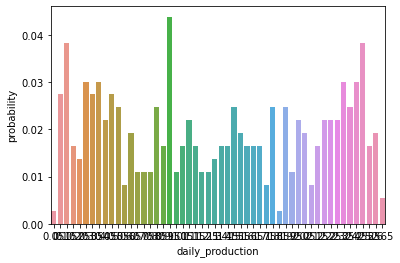

In [32]:
sns.barplot(data=distribution.sort_values('daily_production'),x='daily_production',y='probability')

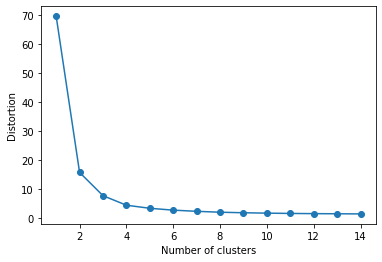

In [33]:
# calculate distortion for a range of number of cluster
NO_CLUSTER = 15
distortions = []
for i in range(1, NO_CLUSTER):
    km = KMeans(
        n_clusters=i, init='k-means++',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(production_scenarios_hourly)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, NO_CLUSTER), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

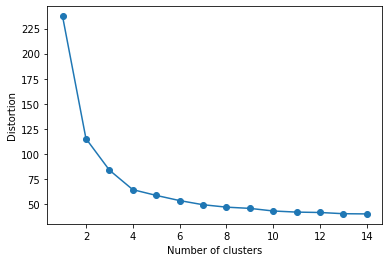

In [34]:
# calculate distortion for a range of number of cluster
NO_CLUSTER = 15
distortions = []
for i in range(1, NO_CLUSTER):
    km = KMedoids(n_clusters=i, init='k-medoids++', random_state = 0)
    km.fit(production_scenarios_hourly)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, NO_CLUSTER), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

Using three clusters seems to be a good choice

In [35]:
km = km = KMedoids(n_clusters=4, init='k-medoids++', random_state = 0)

km.fit(production_scenarios_hourly)
distortions.append(km.inertia_)
centers = km.cluster_centers_

In [36]:
#Get probabilities
prediction = km.predict(production_scenarios_hourly)
prediction = pd.Series(prediction)
probability = list(prediction.value_counts()/len(prediction))
probability

[0.284, 0.275, 0.224, 0.217]

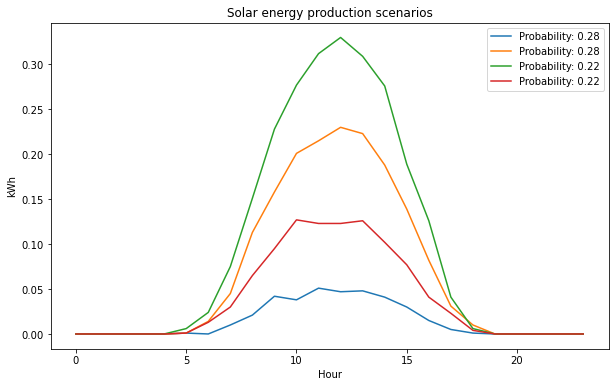

In [37]:
#Plot
fig, ax = plt.subplots(figsize=(10,6))

for i,center in enumerate(centers):
    plt.plot(center, label="Probability: "+str(round(probability[i],2)))


ax.set_title('Solar energy production scenarios')
ax.set_xlabel('Hour')
ax.set_ylabel('kWh')

plt.legend()
plt.show()

fig.savefig("figures//s_energy_scenario.png")

In [38]:
#Convert to Dataframe
dfScenarios = pd.DataFrame(centers)
#Get Daily production
dfDailyProduction = dfScenarios.sum(axis=1)
#Add probabilities
dfDailyProduction['probabilities'] = list(probability)
dfScenarios['probabilities'] = list(probability)
#Transform
dfScenarios = dfScenarios.T
dfDailyProduction = dfDailyProduction.T
dfScenarios.head()

,0,1,2,3
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0


In [39]:
#Save as csv
dfScenarios.to_csv('Output_Scenarios//solor_production_scenarios.csv',index=False)

# Wind energy production

## Descriptive Analysis

In [40]:
#https://data.fingrid.fi/open-data-forms/search/en/?selected_datasets=75

In [41]:
#Read in Data and drop unnecessary
dfWind = pd.read_csv('Input_Data//wind_data.csv')
dfWind.columns = ['Start_Time','End_Time','Start_Time2','End_Time2','Generation']
dfWind.drop(['End_Time','Start_Time2','End_Time2'],axis=1,inplace=True)
dfWind.head()

,Start_Time,Generation
0,2018-12-31 23:00:00,1468.0
1,2019-01-01 00:00:00,1427.0
2,2019-01-01 01:00:00,1352.0
3,2019-01-01 02:00:00,1177.0
4,2019-01-01 03:00:00,1001.0


In [42]:
#Get month,day and hour
dfWind['Start_Time'] = pd.to_datetime(dfWind['Start_Time'])
dfWind['month'] = dfWind['Start_Time'].dt.month
dfWind['day'] = dfWind['Start_Time'].dt.day
dfWind['hour'] = dfWind['Start_Time'].dt.hour
dfWind.drop('Start_Time',axis=1,inplace=True)
dfWind.head()

,Generation,month,day,hour
0,1468.0,12,31,23
1,1427.0,1,1,0
2,1352.0,1,1,1
3,1177.0,1,1,2
4,1001.0,1,1,3


In [43]:
#Only use days with full data
dfControl = dfWind.value_counts(['month','day'])
dfControl = dfControl.reset_index()
dfControl = dfControl[dfControl[0] == 24]
dfControl.drop(0,axis=1,inplace=True)
dfWind_Fin = dfControl.merge(dfWind, on=['month','day'], how='inner')

In [44]:
dfWind_Fin['Generation'] = MinMaxScaler().fit_transform(dfWind_Fin['Generation'].to_numpy().reshape(-1,1))
dfWind_Fin['Generation'] = round(dfWind_Fin['Generation'],2)

<AxesSubplot:xlabel='month', ylabel='Generation'>

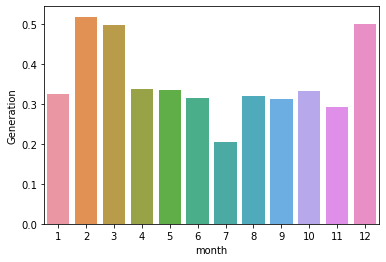

In [45]:
sns.barplot(data=dfWind_Fin.groupby('month').mean().reset_index(),x='month',y='Generation')

<AxesSubplot:xlabel='hour', ylabel='Generation'>

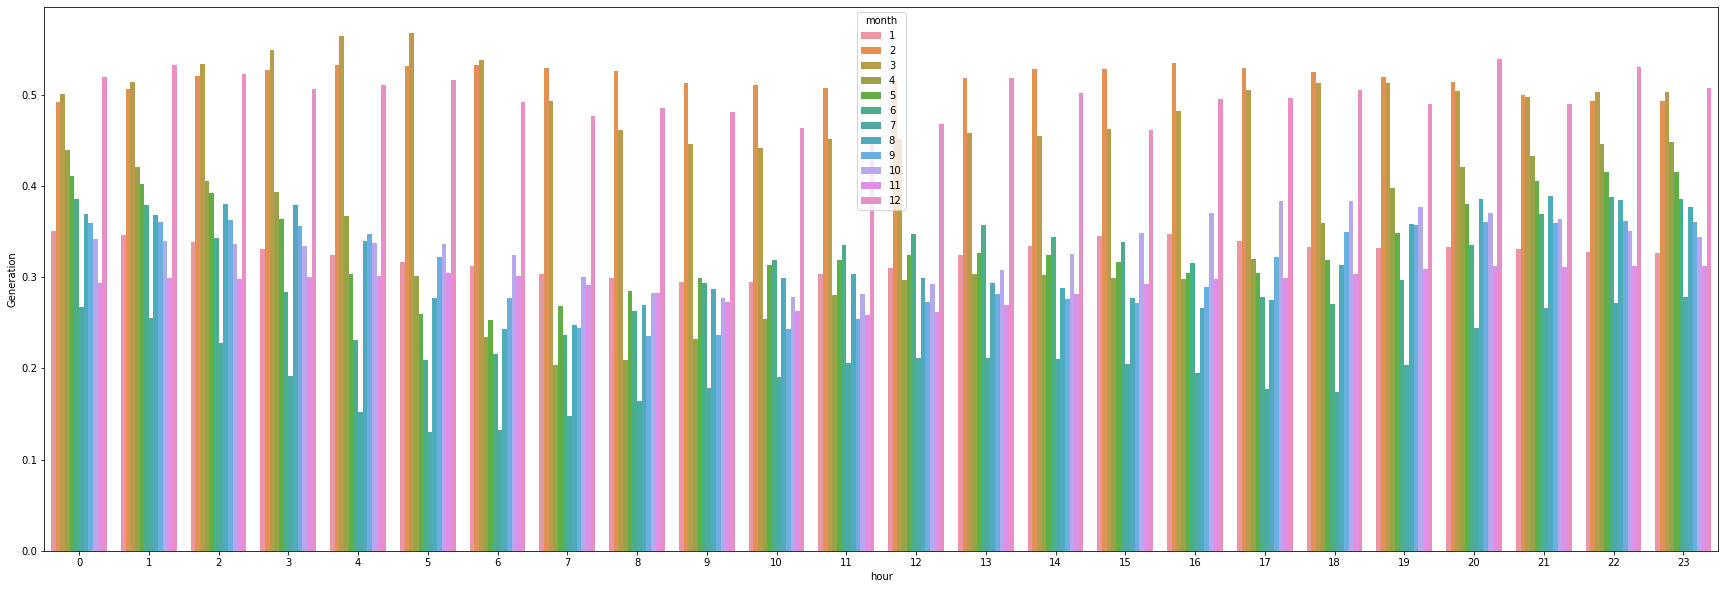

In [46]:
fig, ax = plt.subplots(figsize=(30,10))
sns.barplot(data=dfWind_Fin.groupby(['month','hour']).mean().reset_index(),x='hour',y='Generation',hue='month')

<AxesSubplot:xlabel='Generation', ylabel='count'>

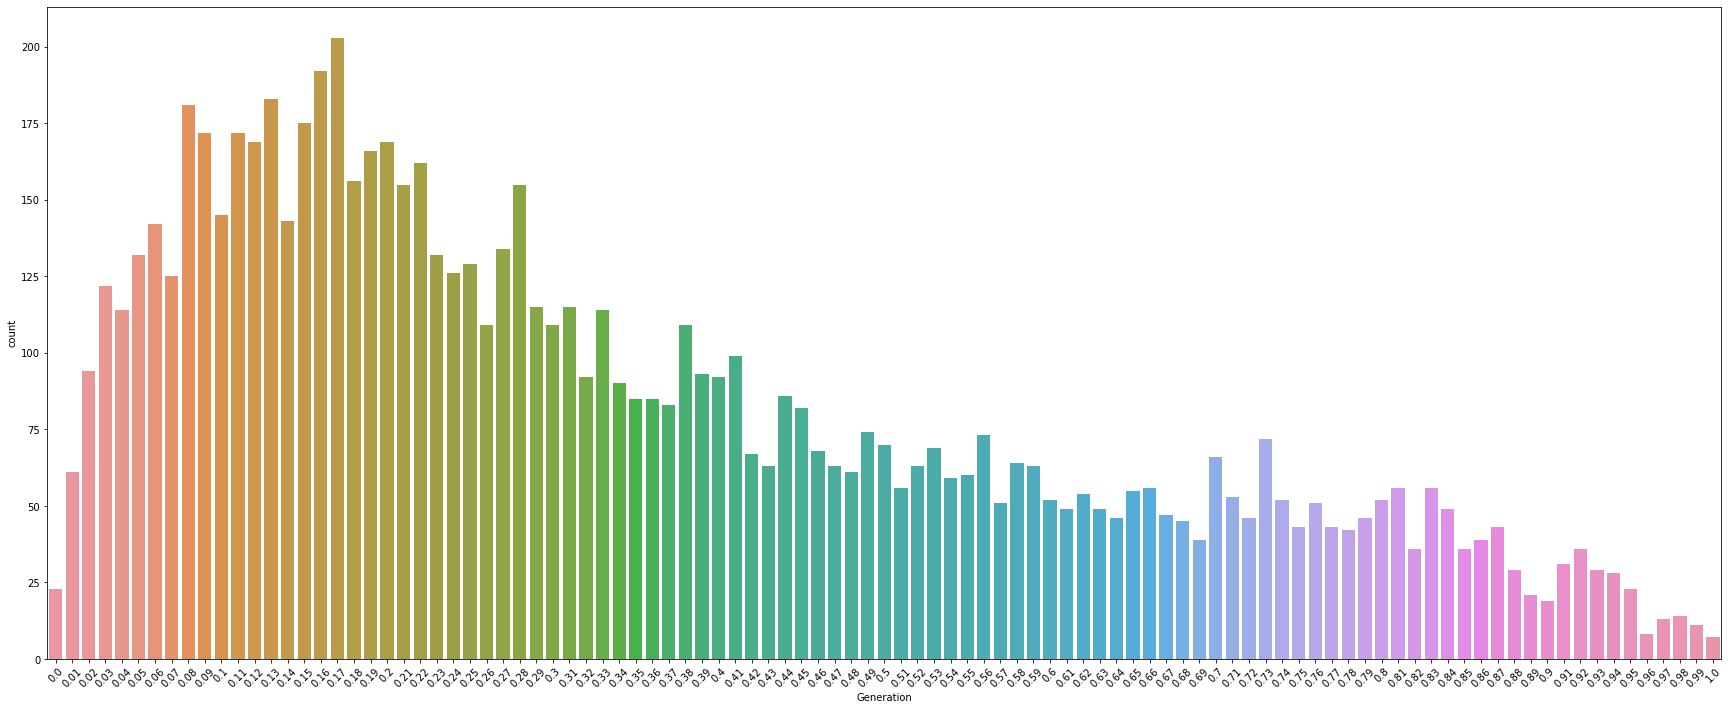

In [47]:
fig, axs = plt.subplots(figsize=(30,12))
plt.xticks(rotation=45)
sns.countplot(data=dfWind_Fin,x='Generation')

In [48]:
hourly_Production = dfWind_Fin.sort_values(['month','day','hour'])['Generation'].values

maxProcution = 12
factor = 0.75

days = []
day = []
for h, value in enumerate(hourly_Production):
    day.append(value*maxProcution*factor)
    if len(day) == 24:
        days.append(day)
        day = []
len(days)

344

In [49]:
dfDays = pd.DataFrame(days)
dfDays

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,7.02,6.66,5.76,4.95,4.05,3.15,2.07,1.35,1.17,1.26,...,4.59,5.04,5.49,5.76,6.21,6.30,6.39,6.39,6.30,6.03
1,5.94,6.12,6.12,6.03,6.12,6.39,6.66,6.57,6.75,6.93,...,6.75,6.75,6.84,6.84,6.57,6.57,6.66,6.39,6.03,5.76
2,5.22,4.41,3.60,2.88,2.52,2.25,2.07,1.80,1.80,1.98,...,6.66,7.20,7.74,7.92,7.56,7.02,6.30,5.04,4.14,3.51
3,3.06,2.79,2.70,2.43,2.43,2.43,2.34,1.98,1.80,1.17,...,1.08,1.17,1.17,1.26,1.08,0.99,1.08,0.99,0.99,0.90
4,0.90,0.81,0.81,0.81,0.72,0.54,0.36,0.36,0.27,0.27,...,0.09,0.18,0.18,0.18,0.27,0.45,0.63,0.90,1.44,1.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,1.17,1.17,1.26,1.44,1.53,1.62,1.71,1.98,2.07,1.98,...,2.16,1.98,2.07,2.25,2.25,2.43,2.43,2.34,2.43,2.52
340,1.89,2.16,2.70,2.97,2.97,2.79,2.70,2.61,2.88,2.79,...,2.16,2.43,2.52,2.43,2.52,2.79,2.70,2.43,2.61,2.61
341,0.45,0.45,0.45,0.54,0.54,0.54,0.54,0.54,0.54,0.54,...,0.72,0.81,0.81,0.81,0.81,0.90,0.99,1.08,0.99,1.17
342,1.71,1.89,2.16,2.88,3.87,4.95,5.22,5.67,6.12,6.39,...,7.65,7.74,7.65,7.65,7.83,7.83,7.83,7.92,7.83,7.83


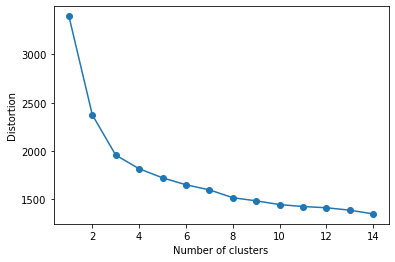

In [50]:
NO_CLUSTER = 15
distortions = []
for i in range(1, NO_CLUSTER):
    km = KMedoids(n_clusters=i, init='k-medoids++', random_state = 0)
    km.fit(dfDays)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, NO_CLUSTER), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

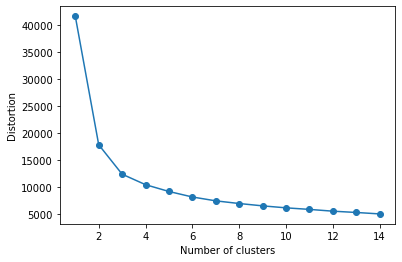

In [51]:
# calculate distortion for a range of number of cluster
NO_CLUSTER = 15
distortions = []
for i in range(1, NO_CLUSTER):
    km = KMeans(
        n_clusters=i, init='k-means++',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(dfDays)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, NO_CLUSTER), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [52]:
km = KMedoids(n_clusters=3, init='k-medoids++', random_state = 0)

km.fit(dfDays)
distortions.append(km.inertia_)
centers = km.cluster_centers_

In [53]:
#Get probabilities
prediction = km.predict(dfDays)
prediction = pd.Series(prediction)
probability = list(prediction.value_counts()/len(prediction))
probability

[0.4680232558139535, 0.3313953488372093, 0.2005813953488372]

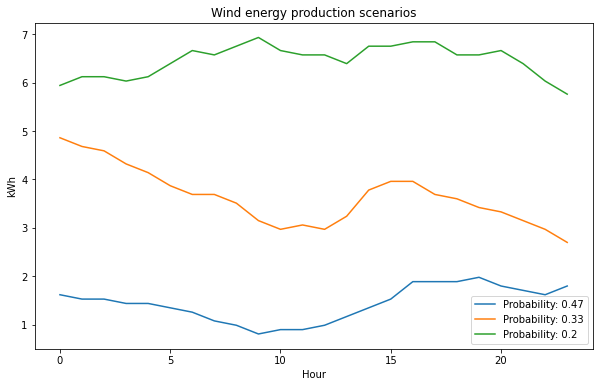

In [54]:
#Plot
fig, ax = plt.subplots(figsize=(10,6))

for i,center in enumerate(centers):
    plt.plot(center, label="Probability: "+str(round(probability[i],2)))


ax.set_title('Wind energy production scenarios')
ax.set_xlabel('Hour')
ax.set_ylabel('kWh')

plt.legend()
plt.show()

fig.savefig("figures//w_energy_scenario.png")

In [55]:
dfProcutionWind = pd.DataFrame(centers)
dfProcutionWind['probability'] = probability
dfProcutionWind = dfProcutionWind.T

dfProcutionWind.to_csv('Output_Scenarios//wind_production_scenarios.csv',index=False)

dfProcutionWind.head()

,0,1,2
0,1.62,4.86,5.94
1,1.53,4.68,6.12
2,1.53,4.59,6.12
3,1.44,4.32,6.03
4,1.44,4.14,6.12


# Energy prices (Day Ahead)

## Descriptive Analysis

In [56]:
#Load Data
dfEnergyPrices_DA = pd.read_csv('Input_Data//auction_spot_germany_luxembourg_2019.csv',sep=';',skiprows=1)

In [57]:
#Filter for relevant data
useColumns = ['Delivery day']

for column in dfEnergyPrices_DA.columns:
    if 'Hour' in column and 'Rush' not in column:
        useColumns.append(column)

dfEnergyPrices_DA = dfEnergyPrices_DA[useColumns]
dfEnergyPrices_DA.head()

,Delivery day,Hour1,Hour2,Hour3A,Hour3B,Hour4,Hour5,Hour6,Hour7,Hour8,...,Hour15,Hour16,Hour17,Hour18,Hour19,Hour20,Hour21,Hour22,Hour23,Hour24
0,31.12.2019,"24,14","22,12","13,01",NaN,"4,97","9,81","18,37","23,50","27,17",...,"38,00","39,58","42,28","46,06","47,73","46,00","42,20","39,74","38,88","37,39"
1,30.12.2019,"11,07","11,84","6,16",NaN,"1,40","4,81","16,43","26,90","30,38",...,"31,53","33,61","35,25","38,09","39,35","31,58","30,68","29,67","29,68","24,33"
2,29.12.2019,"30,60","28,10","26,92",NaN,"22,85","20,97","21,31","22,72","25,10",...,"30,80","32,86","33,97","39,53","41,16","39,60","38,14","32,00","30,11","25,52"
3,28.12.2019,"30,17","29,50","29,43",NaN,"28,20","28,53","27,40","29,20","31,63",...,"34,91","35,86","39,86","40,79","43,75","43,29","39,62","35,39","34,75","30,17"
4,27.12.2019,"31,17","30,02","28,67",NaN,"28,70","29,19","31,03","33,10","38,89",...,"42,20","45,13","46,53","49,38","44,88","43,99","39,52","36,67","35,38","33,57"


In [58]:
#Fullfil numpy requirements
for i in range(1,len(useColumns)):
    dfEnergyPrices_DA[useColumns[i]] = dfEnergyPrices_DA[useColumns[i]].str.replace(',','.')
    dfEnergyPrices_DA[useColumns[i]] = dfEnergyPrices_DA[useColumns[i]].astype(float)

In [59]:
#Solve problems through time changeover
#Combine 3A and 3B to 3
dfEnergyPrices_DA = dfEnergyPrices_DA.fillna(0)
dfEnergyPrices_DA['Hour3'] = dfEnergyPrices_DA['Hour3A']+dfEnergyPrices_DA['Hour3B']
dfEnergyPrices_DA.drop(['Hour3A','Hour3B'],axis=1,inplace=True)
useColumns.remove('Hour3B')
useColumns[3] = 'Hour3'

In [60]:
#Get Final data to use and add month
dfEnergyPrices_DA_Fin = dfEnergyPrices_DA[useColumns]
dfEnergyPrices_DA_Fin['month'] = pd.to_datetime(dfEnergyPrices_DA_Fin['Delivery day']).dt.month
dfEnergyPrices_DA_Fin.head()

F:\Anaconda\envs\atis_2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Delivery day,Hour1,Hour2,Hour3,Hour4,Hour5,Hour6,Hour7,Hour8,Hour9,...,Hour16,Hour17,Hour18,Hour19,Hour20,Hour21,Hour22,Hour23,Hour24,month
0,31.12.2019,24.14,22.12,13.01,4.97,9.81,18.37,23.50,27.17,36.56,...,39.58,42.28,46.06,47.73,46.00,42.20,39.74,38.88,37.39,12
1,30.12.2019,11.07,11.84,6.16,1.40,4.81,16.43,26.90,30.38,32.04,...,33.61,35.25,38.09,39.35,31.58,30.68,29.67,29.68,24.33,12
2,29.12.2019,30.60,28.10,26.92,22.85,20.97,21.31,22.72,25.10,27.52,...,32.86,33.97,39.53,41.16,39.60,38.14,32.00,30.11,25.52,12
3,28.12.2019,30.17,29.50,29.43,28.20,28.53,27.40,29.20,31.63,34.61,...,35.86,39.86,40.79,43.75,43.29,39.62,35.39,34.75,30.17,12
4,27.12.2019,31.17,30.02,28.67,28.70,29.19,31.03,33.10,38.89,38.55,...,45.13,46.53,49.38,44.88,43.99,39.52,36.67,35.38,33.57,12


In [61]:
#Get average monthly price
avgPrices = dfEnergyPrices_DA_Fin.drop('Delivery day',axis=1).groupby('month').mean()

#Reset index and set column names
xColumns = avgPrices.columns
avgPrices = avgPrices.reset_index()
avgPrices.head()

,month,Hour1,Hour2,Hour3,Hour4,Hour5,Hour6,Hour7,Hour8,Hour9,...,Hour15,Hour16,Hour17,Hour18,Hour19,Hour20,Hour21,Hour22,Hour23,Hour24
0,1,39.137742,36.820968,35.745161,35.020323,35.146129,36.625484,43.431935,51.568710,55.543548,...,46.795806,47.471290,49.047742,54.792581,56.762581,54.187742,49.487742,45.072581,44.411613,38.980000
1,2,33.728214,32.370714,31.773929,31.053214,31.448929,33.831786,41.469643,47.066786,48.092500,...,37.616071,39.224643,41.854286,46.769643,50.746429,51.322857,48.139286,43.395000,42.313214,38.506429
2,3,29.462903,27.060000,24.880323,24.960968,25.876129,28.876129,34.737097,39.402903,40.882258,...,31.026452,31.564194,33.925806,39.185161,43.434194,47.031290,43.461935,38.950645,37.366774,33.576129
3,4,32.890333,31.014667,29.913667,29.453333,30.102000,32.761333,39.306667,44.464667,46.265333,...,27.136667,28.899667,31.644333,37.691000,43.373000,46.367000,44.890333,41.396333,38.325667,33.385667
4,5,32.755161,30.841290,29.643548,28.954194,29.013871,31.101613,37.590645,44.172258,46.457742,...,34.709677,35.126452,36.597097,40.852581,45.017419,47.184516,47.021935,44.833226,43.202903,38.700323


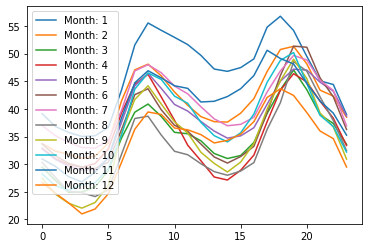

In [62]:
for i,row in enumerate(avgPrices[xColumns].values):
    plt.plot(row,label='Month: '+str(i+1))

plt.legend()
plt.show()

A pattern can also be observed in the prices, which is the same in all months and only differs in the price level. It also has similarities with the pattern of demand data-

## Scenario Generation
Use real world data

In [63]:
#Drop unnecessary
dfEnergyPrices_DA_Fin = dfEnergyPrices_DA_Fin.drop(['Delivery day','month'],axis=1)

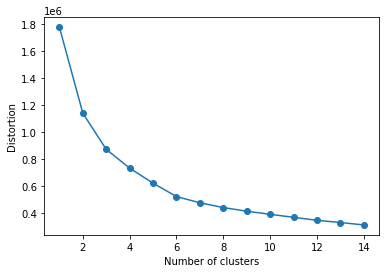

In [64]:
# calculate distortion for a range of number of cluster
NO_CLUSTER = 15
distortions = []
for i in range(1, NO_CLUSTER):
    km = KMeans(
        n_clusters=i, init='k-means++',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(dfEnergyPrices_DA_Fin)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, NO_CLUSTER), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

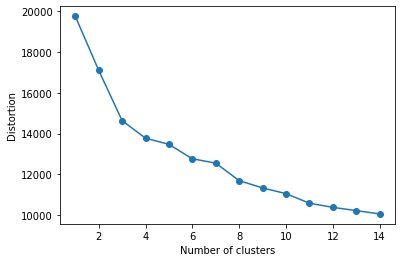

In [65]:
# calculate distortion for a range of number of cluster
NO_CLUSTER = 15
distortions = []
for i in range(1, NO_CLUSTER):
    km = KMedoids(n_clusters=i, init='k-medoids++', random_state = 0)
    km.fit(dfEnergyPrices_DA_Fin)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, NO_CLUSTER), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

Use KMediods as it produces clearer results

In [66]:
km = KMedoids(n_clusters=4, init='k-medoids++', random_state = 0)

km.fit(dfEnergyPrices_DA_Fin)
distortions.append(km.inertia_)
centers = km.cluster_centers_
centers

array([[ 3.526e+01,  3.488e+01,  3.295e+01,  3.506e+01,  3.606e+01,
         3.806e+01,  4.912e+01,  5.466e+01,  5.458e+01,  5.308e+01,
         5.209e+01,  4.973e+01,  4.374e+01,  4.505e+01,  4.558e+01,
         4.601e+01,  4.979e+01,  5.196e+01,  5.425e+01,  5.434e+01,
         5.075e+01,  4.406e+01,  4.327e+01,  4.013e+01],
       [ 2.277e+01,  8.670e+00,  1.840e+00,  9.000e-02,  7.000e-02,
         3.000e-02, -2.810e+00, -4.000e-02,  2.860e+00,  8.000e-02,
         1.100e-01,  3.330e+00,  4.020e+00,  1.060e+00,  2.000e+00,
         4.750e+00,  1.500e+01,  2.272e+01,  3.180e+01,  3.849e+01,
         2.483e+01,  1.992e+01,  2.430e+01,  1.947e+01],
       [ 3.591e+01,  3.354e+01,  3.298e+01,  3.292e+01,  3.330e+01,
         3.350e+01,  4.192e+01,  4.945e+01,  4.880e+01,  4.399e+01,
         4.134e+01,  4.213e+01,  3.916e+01,  3.732e+01,  3.699e+01,
         3.705e+01,  3.884e+01,  4.408e+01,  4.895e+01,  5.319e+01,
         5.147e+01,  4.806e+01,  4.773e+01,  4.265e+01],
       [ 2.62

In [67]:
#Get probabilities
prediction = km.predict(dfEnergyPrices_DA_Fin)
prediction = pd.Series(prediction)
probability = list(prediction.value_counts()/len(prediction))
probability

[0.33424657534246577,
 0.29863013698630136,
 0.29863013698630136,
 0.0684931506849315]

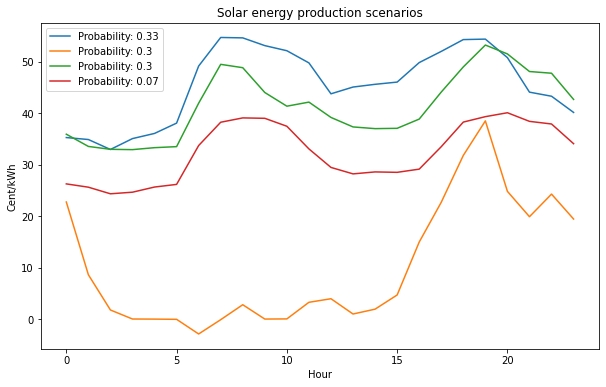

In [68]:
#Plot
fig, ax = plt.subplots(figsize=(10,6))
for i,center in enumerate(centers):
    plt.plot(center, label="Probability: "+str(round(probability[i],2)))

ax.set_title('Solar energy production scenarios')
ax.set_xlabel('Hour')
ax.set_ylabel('Cent/kWh')

plt.legend()
plt.show()

fig.savefig("figures//cost_scenario.png")


In [69]:
dfPrices = pd.DataFrame(centers)
dfPrices['probabilities'] = probability
dfPrices = dfPrices.T
dfPrices

,0,1,2,3
0,35.260000,22.77000,35.91000,26.280000
1,34.880000,8.67000,33.54000,25.640000
2,32.950000,1.84000,32.98000,24.360000
3,35.060000,0.09000,32.92000,24.670000
4,36.060000,0.07000,33.30000,25.670000
5,38.060000,0.03000,33.50000,26.180000
6,49.120000,-2.81000,41.92000,33.710000
7,54.660000,-0.04000,49.45000,38.230000
8,54.580000,2.86000,48.80000,39.070000
9,53.080000,0.08000,43.99000,38.990000


In [70]:
dfPrices.to_csv('Output_Scenarios//price_scenarios.csv',index=False)